In [1]:
using Pkg
# Pkg.activate(".")
using AxisKeys
using Revise
using EasyHybrid
using Lux
using Optimisers
using Random
using LuxCore
using CSV, DataFrames
using EasyHybrid.MLUtils
using Statistics
using Plots
using Flux
using NNlib 
using JLD2

In [2]:
testid = "01_uniNN"
version = "v20251125";
results_dir = joinpath(@__DIR__, "eval");
target_names = [:BD, :SOCconc, :CF, :SOCdensity];

# input
df = CSV.read(joinpath(@__DIR__, "data/lucas_preprocessed_$version.csv"), DataFrame; normalizenames=true)

# scales
scalers = Dict(
    :SOCconc   => 0.151, # g/kg, log(x+1)*0.151
    :CF        => 0.263, # percent, log(x+1)*0.263
    :BD        => 0.529, # g/cm3, x*0.529
    :SOCdensity => 0.167, # kg/m3, log(x)*0.167
);

# predictor
predictors = Symbol.(names(df))[18:end-6]; # CHECK EVERY TIME 
nf = length(predictors)

# search space
hidden_configs = [ 
    (512, 256, 128, 64, 32, 16),
    (512, 256, 128, 64, 32), 
    (256, 128, 64, 32, 16),
    (256, 128, 64, 32),
    (256, 128, 64),
    (128, 64, 32, 16),
    (128, 64, 32),
    (64, 32, 16)
];
batch_sizes = [128, 256, 512];
lrs = [1e-3, 5e-4, 1e-4];
activations = [relu, swish, gelu];

configs = [(h=h, bs=bs, lr=lr, act=act)
    for h in hidden_configs
    for bs in batch_sizes
    for lr in lrs
    for act in activations]

println(length(configs))
# cross-validation
k = 5;
# folds_df = CSV.read("folds_assignment.csv", DataFrame)
# folds = folds_df.fold
# folds = collect(folds)
folds = make_folds(df, k = k, shuffle = true);
# d = load("$(testid)_3folds_results.jld")
# a_list_param = d["rlt_list_param"]
# a_list_pred  = d["rlt_list_pred"]
rlt_list_param = Vector{DataFrame}(undef, k)
rlt_list_pred = Vector{DataFrame}(undef, k)  

@info "Threads: $(Threads.nthreads())"


216


[ Info: Threads: 96


In [3]:
@time for test_fold in 1:k 
    @info "Fold $test_fold"

    train_folds = setdiff(1:k, test_fold)
    train_idx = findall(in(train_folds), folds)
    train_df = df[train_idx, :]
    test_idx  = findall(==(test_fold), folds)
    test_df_full = df[test_idx, :]

    fold_params = DataFrame()
    preds_this_fold = Dict{Symbol, DataFrame}()

    for tgt in target_names
        @info "Target $tgt"

        # dropmissing for train one by one
        train_df_t = dropmissing(train_df, tgt)
        if nrow(train_df_t) == 0
            @warn "No training rows for $tgt — filling NaN"
            test_df_full[!, Symbol("pred_", tgt)] = fill(NaN32, nrow(test_df_full))
            continue
        end

        lk = ReentrantLock()
        best_loss   = Inf
        best_cfg    = nothing
        best_rlt    = nothing      
        best_model  = nothing    
        best_model_path = nothing

        ########################
        # hyperparam search
        ########################
        Threads.@threads for i in 1:length(configs)
            cfg = configs[i]

            h  = cfg.h
            bs = cfg.bs
            lr = cfg.lr
            act = cfg.act
            println("Testing h=$h, bs=$bs, lr=$lr, activation=$act")

            nn_local = constructNNModel(
                predictors, [tgt];
                hidden_layers = collect(h),
                activation = act,
                scale_nn_outputs = true,
                input_batchnorm = false
            )

            rlt = train(
                nn_local, train_df_t, ();
                nepochs = 200,
                batchsize = bs,
                opt = AdamW(lr),
                training_loss = :mse,
                loss_types = [:mse, :r2],
                shuffleobs = true,
                file_name = "$(testid)_$(tgt)_config$(i)_fold$(test_fold).jld2",
                patience = 15,
                return_model = :best,  
                plotting = false,
                show_progress = false,
                hybrid_name = "$(testid)_$(tgt)_config$(i)_fold$(test_fold)"
            )

            lock(lk) do
                if rlt.best_loss < best_loss
                    best_loss = rlt.best_loss
                    best_cfg  = (h=h, bs=bs, lr=lr, act=act)
                    best_rlt  = rlt              
                    best_model = nn_local     
                    best_model_path = "$(testid)_$(tgt)_config$(i)_fold$(test_fold)"
                end
            end
        end

        # if all hyperparameter fails
        if best_rlt === nothing
            @warn "All configs failed for target=$tgt on fold=$test_fold — recording NaN"

            push!(fold_params, (
                fold       = test_fold,
                target     = String(tgt),
                h          = "nothing",
                bs         = NaN,
                lr         = NaN,
                act        = "nothing",
                r2         = NaN,
                mse        = NaN,
                best_epoch = NaN,
                best_model_path = "none"
            ))

            test_df_full[!, Symbol("pred_", tgt)] = fill(NaN32, nrow(test_df_full))
            continue
        end

        ########################
        # get the best hyper combi
        ########################
        agg = :sum
        r2s  = map(vh -> getproperty(vh, agg), best_rlt.val_history.r2)
        mses = map(vh -> getproperty(vh, agg), best_rlt.val_history.mse)
        be = max(best_rlt.best_epoch, 1)

        push!(fold_params, (
            fold       = test_fold,
            target     = String(tgt),
            h          = string(best_cfg.h),
            bs         = best_cfg.bs,
            lr         = best_cfg.lr,
            act        = string(best_cfg.act),
            r2         = r2s[be],
            mse        = mses[be],
            best_epoch = be,
            best_model_path = best_model_path
        ))

        ########################
        # predict
        ########################
        ps, st = best_rlt.ps, best_rlt.st     
        # println("full test", size(test_df_full))

        x_test, _ = prepare_data(best_model, test_df_full)
        test_df_t = filter(tgt => x -> !isnan(x), test_df_full)
        # println("test_df_t", size(test_df_t))
        x_test, _ = prepare_data(best_model, test_df_t)
        # println("prepared data", size(x_test))

        
        ŷ_test, _ = best_model(x_test, ps, LuxCore.testmode(st))
        pred_df = DataFrame(
            row_id = test_df_t.row_id,
            pred = ŷ_test[tgt]
        )
        preds_this_fold[tgt] = pred_df

        ############
        ## clean tmp files....tooo much
        ##########
        cp(joinpath("output_tmp", best_model_path * ".jld2"), joinpath("model", best_model_path * ".jld2"); force=true)
        for f in filter(x -> isfile(x), readdir("output_tmp"; join=true))
            rm(f; force=true)
        end

    end
    df_fold = test_df_full

    for tgt in target_names
        df_fold = leftjoin(df_fold, preds_this_fold[tgt], on=:row_id)
        rename!(df_fold, :pred => Symbol("pred_", tgt))
    end
    
    rlt_list_pred[test_fold] = df_fold
    rlt_list_param[test_fold] = fold_params
end

rlt_param = vcat(rlt_list_param...)
rlt_pred  = vcat(rlt_list_pred...)


# folds_df = DataFrame(fold = folds)
# CSV.write("folds_assignment.csv", folds_df)
# jldsave("$(testid)_3folds_results.jld";
#     rlt_list_param = rlt_list_param,
#     rlt_list_pred  = rlt_list_pred
# )

CSV.write(joinpath(results_dir, "$(testid)_cv.pred_$version.csv"), rlt_pred)
CSV.write(joinpath(results_dir, "$(testid)_hyperparams_$version.csv"), rlt_param)


[ Info: Fold 1
[ Info: Target BD


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=swish
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=swish
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16)

┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disa

Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots 

Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu


┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015203852373532507
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015203852373532507
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015676258658052465
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015676258658052465
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.015530583441428408
└ @ EasyHybrid /opt/julia/pack

Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015100633757010937
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015100633757010937
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.01584485345701242
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.01584485345701242
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/tr

Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015159460026724476
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015159460026724476
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015319807807483082
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015319807807483082
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.015311612247953348
└ @ EasyHybrid /opt/julia/pack

Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu


┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.01578210484700965
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.01578210484700965
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=relu


┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015383906036060829
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015383906036060829
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.022507714845301854
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.022507714845301854


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.01492972789876034
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.01492972789876034
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.015238835599385034
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.015238835599385034
┌ Wa

Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015777988649824364
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015777988649824364
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.01593229603239256
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.01593229603239256
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.01989570800350804
└ @ EasyHybrid /opt/julia/packag

Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.021901837681743603
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.021901837681743603
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015953633749122648
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015953633749122648
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.015556750662139069
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.015556750662139069
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: 

Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=relu


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.014878641696474229
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.014878641696474229
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.01578630459225745
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.01578630459225745
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Inf

Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014827465797163831
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014827465797163831
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015693780655227692
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch

Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=relu


┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015402149052002444
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015402149052002444
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 49 with best validation loss wrt mse: 0.01511321950001998
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 34 of 200 epochs with best validation loss

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015142933686435647
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015142933686435647


Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.02433984723367212
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.02433984723367212


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.01927758255143565
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.01927758255143565


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 66 with best validation loss wrt mse: 0.022596839360185146
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 51 of 200 epochs with best validation loss wrt mse: 0.022596839360185146


Testing h=(64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014723047668738653
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014723047668738653


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.020507115798406726
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.020507115798406726
┌ Warning: Early stopping at epoch 64 with best validation loss wrt mse: 0.0161899

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015213269854233148
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015213269854233148


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 68 with best validation loss wrt mse: 0.022412244247875853
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 53 of 200 epochs with best validation loss wrt mse: 0.022412244247875853
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 74 with best validation loss wrt mse: 0.01563345121439498
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 59 of 200 epochs with best validation loss wrt mse: 0.01563345121439498
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.01527089

Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 37 with best validation loss wrt mse: 0.02494009898866446
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 22 of 200 epochs with best validation loss wrt mse: 0.02494009898866446


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.015231076949556471
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.015231076949556471
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.032663192160123866
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.032663192160123866


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 104 with best validation loss wrt mse: 0.015319381805498392
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 89 of 200 epochs with best validation loss wrt mse: 0.015319381805498392


Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 107 with best validation loss wrt mse: 0.025828403075528472
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 92 of 200 epochs with best validation loss wrt mse: 0.025828403075528472


Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.02224964262370223
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.02224964262370223


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 52 with best validation loss wrt mse: 0.015339115242455575
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 37 of 200 epochs with best validation loss wrt mse: 0.015339115242455575


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015013036026178067
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015013036026178067
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015708357028850702
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015708357028850702
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.02135701768984227
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ In

Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015993853536096145
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015993853536096145
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.015295236363367383
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.015295236363367383
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.016137306594311583
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ 

Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.015320052517316692
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.015320052517316692


Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015363444495201212
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015363444495201212
┌ Warning: Early stopping at epoch 54 with best validation loss wrt mse: 0.01597893545783277
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 39 of 200 epochs with best validation loss wrt mse: 0.01597893545783277


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 92 with best validation loss wrt mse: 0.02510202865607779
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 77 of 200 epochs with best validation loss wrt mse: 0.02510202865607779


Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.026368792148745504
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.026368792148745504
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.024315704680401985
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.024315704680401985


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 90 with best validation loss wrt mse: 0.026948766486651544
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 75 of 200 epochs with best validation loss wrt mse: 0.026948766486651544


Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.015116036281616327
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.015116036281616327
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 83 with best validation loss wrt mse: 0.0157727

Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 58 with best validation loss wrt mse: 0.01613287289606784
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 43 of 200 epochs with best validation loss wrt mse: 0.01613287289606784


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.0149402466203961
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.0149402466203961
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.01489193410347661
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.01489193410347661
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.01876168320669738
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Re

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.015565389776337913
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.015565389776337913
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015035796452627329
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015035796452627329
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.01580180933098049
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.01580180933098049
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 71 with best validation loss wrt mse: 0.024514629688638927
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 

Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.015867365101631534
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.015867365101631534


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.022033037304392218
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.022033037304392218
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015415949055334912
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015415949055334912
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/Hyb

Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 39 with best validation loss wrt mse: 0.025357251755786184
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 24 of 200 epochs with best validation loss wrt mse: 0.025357251755786184
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.02482931982157327
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.02482931982157327


Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.01530978588491955
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.01530978588491955
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015845132949256897
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015845132949256897
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.015346541839544748
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.015346541839544748


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.022309086321538173
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.022309086321538173


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.01519310307175855
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.01519310307175855


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 72 with best validation loss wrt mse: 0.03202552375643488
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 57 of 200 epochs with best validation loss wrt mse: 0.03202552375643488


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.02894572052679354
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.02894572052679354


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.01555206956761232
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validatio

Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 94 with best validation loss wrt mse: 0.02440910006145815
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 79 of 200 epochs with best validation loss wrt mse: 0.02440910006145815


Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015151625503250452
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015151625503250452
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 39 with best validation loss wrt mse: 0.024288408796003347
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 24 of 200 epochs with best validation loss wrt mse: 0.024288408796003347


Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 39 with best validation loss wrt mse: 0.01513621054332035
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 24 of 200 epochs with best validation loss wrt mse: 0.01513621054332035


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 74 with best validation loss wrt mse: 0.024323251662616018
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 59 of 200 epochs with best validation loss wrt mse: 0.024323251662616018


Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.015299355885321811
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.015299355885321811
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 94 with best validation loss wrt mse: 0.024786186248950223
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 79 of 200 epochs with best validation loss wrt mse: 0.024786186248950223
┌ Warning: Early stopping at epoch 25 with be

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015190683023228294
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015190683023228294


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.015232139365351234
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.015232139365351234


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.015650424061601585
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.015650424061601585
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015970004305443878
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015970004305443878
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best

Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.015298313530608943
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.015298313530608943


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.015043927405050849
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.015043927405050849
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.015534604068138665
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.015534604068138665


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015266156810108376
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015266156810108376
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.014944099014931695
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.014944099014931695


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.024167316096513423
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.024167316096513423
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.0215145734038047
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.01516920928735578
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.01516920928735578
┌ Warning: Early stopping at epoch 69 with best validation loss wrt mse: 0.03158488657326469
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 54 of 200 epochs with best validation loss wrt mse: 0.03158488657326469


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 100 with best validation loss wrt mse: 0.02285509201551393
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 85 of 200 epochs with best validation loss wrt mse: 0.02285509201551393
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.015346126034998365
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.015346126034998365
┌ Warning: Early stopping at epoch 92 with best validation loss wrt mse: 0.030596111124571616
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 77 of 200 epochs with best validation loss wrt mse: 0.030596111124571616


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.015122832012182704
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.015122832012182704
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.015222515452934984
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.015222515452934984
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.022215718853885902
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ I

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015003949029574467
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015003949029574467
[ Info: Returning best model from epoch 200 of 200 epochs with best validation loss wrt mse: 0.031235418957711956


Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.015245348431819
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.015245348431819
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015674630587102903
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015674630587102903
[ Info: Returning best model from epoch 200 of 200 epochs with best validation loss wrt mse: 0.030422350467661383
┌ Warning: Early stopping at epoch 154 with best validation loss wrt mse: 0.03191727513016982
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returni

Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.020927531643558
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.020927531643558
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014938372456497545
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014938372456497545


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.015162649962825948
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.015162649962825948


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.015277598799359695
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.015277598799359695


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 62 with best validation loss wrt mse: 0.015390630635661328
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 47 of 200 epochs with best validation loss wrt mse: 0.015390630635661328
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 69 with best validation loss wrt mse: 0.015983529159400777
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 54 of 200 epochs with best validation loss wrt mse: 0.015983529159400777
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 52 with be

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.01500196320878808
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.01500196320878808
┌ Warning: Early stopping at epoch 87 with best validation loss wrt mse: 0.020905199401731838
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 72 of 200 epochs with best validation loss wrt mse: 0.020905199401731838
┌ Warning: Early stopping at epoch 62 with best validation loss wrt mse: 0.02435261812858608
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 47 of 200 epochs with best validation loss wrt mse: 0.02435261812858608
[ Info: Retur

Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015276869354108989
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015276869354108989


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.024207329749069983
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.024207329749069983
┌ Warning: Early stopping at epoch 71 with best validation loss wrt mse: 0.030982479676531744
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 56 of 200 epochs with best validation loss wrt mse: 0.030982479676531744
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.01490055429901521
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.01490055429901521


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.014778134134236183
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.014778134134236183


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.015042472654801343
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.015042472654801343
┌ Warning: Early stopping at epoch 64 with best validation loss wrt mse: 0.02052370737983216
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 49 of 200 epochs with best validation loss wrt mse: 0.02052370737983216
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.01499212543752451
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.01499212543752451
┌ Warning: Earl

Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.015840468319145075
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.015840468319145075
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.016054167412082307
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.016054167412082307
[ Info: Check the saved output (.png, .mp4, .

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.014925018768326338
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.014925018768326338
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014920451818866972
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.015275684314953072
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validat

Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.014944616690216659
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.014944616690216659
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.01513514968005015
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.01513514968005015


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Returning best model from epoch 200 of 200 epochs with best validation loss wrt mse: 0.0318233998806212
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 110 with best validation loss wrt mse: 0.05243384014832839
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 95 of 200 epochs with best validation loss wrt mse: 0.05243384014832839


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.014851732150283061
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.014851732150283061
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.01512052313855572
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 

Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.015141701309596113
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.015141701309596113
┌ Warning: Early stopping at epoch 68 with best validation loss wrt mse: 0.01599739049630786
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 53 of 200 epochs with best validation loss wrt mse: 0.01599739049630786
┌ Warning: Early stopping at epoch 50 with best validation loss wrt mse: 0.01514549978396346
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 35 of 200 epochs with best validation loss wrt mse: 0.01514549978396346


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 17 with best validation loss wrt mse: 0.014956887438917415
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 2 of 200 epochs with best validation loss wrt mse: 0.014956887438917415
┌ Warning: Early stopping at epoch 58 with best validation loss wrt mse: 0.015078470619138779
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 43 of 200 epochs with best validation loss wrt mse: 0.015078470619138779
[ Info: Returning best model from epoch 198 of 200 epochs with best validation loss wrt mse: 0.03008988218937819
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) fr

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.015167124147370094
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.015167124147370094


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 57 with best validation loss wrt mse: 0.015249114570676181
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 42 of 200 epochs with best validation loss wrt mse: 0.015249114570676181
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 162 with best validation loss wrt mse: 0.026154508340510762
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 147 of 200 epochs with best validation loss wrt mse: 0.026154508340510762
┌ Warning: Early stopping at epoch 74 with best validation loss wrt mse: 0.015261122385598661
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 59 of 200 epochs with best validation loss wrt mse: 0.015261122385598661
[ Info:

Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 124 with best validation loss wrt mse: 0.028496492197284968
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 109 of 200 epochs with best validation loss wrt mse: 0.028496492197284968


Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.0151796521721224
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.0151796521721224


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.015395932736052897
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.015395932736052897
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.015137390945100561
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.015137390945100561


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 104 with best validation loss wrt mse: 0.028762611184395426
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 89 of 200 epochs with best validation loss wrt mse: 0.028762611184395426
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 187 with best validation loss wrt mse: 0.02805500732020153
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 172 of 200 epochs with best validation loss wrt mse: 0.02805500732020153
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 33 with b

Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 154 with best validation loss wrt mse: 0.02928024406208804
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 139 of 200 epochs with best validation loss wrt mse: 0.02928024406208804
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.015928850495978683
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.015928850495978683
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.015196236538721554
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.015196236538721554
[ Info: C

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=swish
Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=swish
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, act

┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyH


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=256

[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disab

Testing h=(128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(128

┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.



Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disab

Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu


┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.006270553795411267
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.006270553795411267
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.006342339826392964
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.006342339826392964
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ 

Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.00626212751230707
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.00626212751230707
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.006259100832031924
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.006259100832031924
┌ Warning: Makie extension not loaded, no plots

Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.006029682210121952
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.006029682210121952
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 41 with best validation loss wrt mse: 0.006221669042610563
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 26 of 200 epochs with best validation loss wrt mse: 0.006221669042610563
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ 

Testing h=(64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.006449778376762388
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.006449778376762388
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006087275772918598
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.006087275772918598
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ 

Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006302284092512232
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.006302284092512232


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.006240899616557465
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.006240899616557465


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.006222126038178237
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.006222126038178237


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 89 with best validation loss wrt mse: 0.007808402550744259
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 74 of 200 epochs with best validation loss wrt mse: 0.007808402550744259


Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 58 with best validation loss wrt mse: 0.007226684653427577
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 43 of 200 epochs with best validation loss wrt mse: 0.007226684653427577


Testing h=(64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.007409074694301151
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.007409074694301151


Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.006141192308987387
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.006141192308987387


Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 68 with best validation loss wrt mse: 0.008757485652343999
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 53 of 200 epochs with best validation loss wrt mse: 0.008757485652343999


Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.006229228344160241
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.006229228344160241
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.006286805582137129
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.006286805582137129
┌ Warning: Early stopping at epoch 79 with be

Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006139420390508899
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.006139420390508899


Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.006398459262044615
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.006398459262044615


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 64 with best validation loss wrt mse: 0.008482151353955828
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 49 of 200 epochs with best validation loss wrt mse: 0.008482151353955828


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.00782478363433227
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.00782478363433227


Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.006278308333616166
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.006278308333616166


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.006437870327936794
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.006437870327936794
┌ Warning: Early stopping at epoch 55 with best validation loss wrt mse: 0.006419684054781724
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 40 of 200 epochs with best validation loss wrt mse: 0.006419684054781724


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 67 with best validation loss wrt mse: 0.006423359048690757
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 52 of 200 epochs with best validation loss wrt mse: 0.006423359048690757


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.006253374099962456
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.006253374099962456


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006165473917474533
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.006165473917474533
[ Info: Plotting disabled.


Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 114 with best validation loss wrt mse: 0.006520719436673648
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 99 of 200 epochs with best validation loss wrt mse: 0.006520719436673648


Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.006398183062048222
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.006398183062048222
┌ Warning: Early stopping at epoch 79 with best validation loss wrt mse: 0.006338054460829485
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 64 of 200 epochs with best validation loss wrt mse: 0.006338054460829485


Testing h=(64, 32, 16), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 51 with best validation loss wrt mse: 0.0064059628713119925
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 36 of 200 epochs with best validation loss wrt mse: 0.0064059628713119925


Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.006267515589907902
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.006267515589907902
┌ Warning: Early stopping at epoch 77 with best validation loss wrt mse: 0.0064474085778282245
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 62 of 200 epochs with best validation loss wrt mse: 0.0064474085778282245


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 75 with best validation loss wrt mse: 0.008086983940920429
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 60 of 200 epochs with best validation loss wrt mse: 0.008086983940920429


Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.006297860414108962
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.006297860414108962
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.0063017997345850155
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.0063017997345850155
┌ Warning: Early stopping at epoch 87 with best validation loss wrt mse: 0.00642500797188976
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 72 of 200 epochs with best validation loss wrt mse: 0.00642500797188976


Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.006432124645086019
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.006432124645086019
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 54 with best validation loss wrt mse: 0.008220826964212245
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 39 of 200 epochs with best validation loss wrt mse: 0.008220826964212245


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.008692113783062668
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.008692113783062668


Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006155205428091104
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.006155205428091104
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.0063133728948662655
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.0063133728948662655


Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 62 with best validation loss wrt mse: 0.007662673306719113
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 47 of 200 epochs with best validation loss wrt mse: 0.007662673306719113


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006182633313555949
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.006182633313555949
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 64 with best validation loss wrt mse: 0.008470911691258212
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 49 of 200 epochs with best validation loss wrt mse: 0.008470911691258212


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 75 with best validation loss wrt mse: 0.006321017214512204
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 60 of 200 epochs with best validation loss wrt mse: 0.006321017214512204


Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.0062135355840868
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.0062135355840868
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.006105681339250806
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.006105681339250806


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 55 with best validation loss wrt mse: 0.006455318125904936
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 40 of 200 epochs with best validation loss wrt mse: 0.006455318125904936


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.007548049075758688
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.007548049075758688


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 70 with best validation loss wrt mse: 0.007460081417045261
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 55 of 200 epochs with best validation loss wrt mse: 0.007460081417045261


Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.006305272509111962
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.006305272509111962
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 70 with best validation loss wrt mse: 0.008072192029271973
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 55 of 200 epochs with best validation loss wrt mse: 0.008072192029271973


Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.00610081769067599
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.00610081769067599


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006194956592826985
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.006194956592826985
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.006208119757578407
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.006208119757578407
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.006283435469741065
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.006283435469741065
┌ Warning: Early stopping at epoch 70 with best validation loss wrt mse: 0.008347521831032998
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 55 of 200 epochs with best validation loss wrt mse: 0.008347521831032998


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 114 with best validation loss wrt mse: 0.007632454807323321
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 99 of 200 epochs with best validation loss wrt mse: 0.007632454807323321


Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.006189722053727379
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.006189722053727379
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006245558256462606
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.006245558256462606


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 76 with best validation loss wrt mse: 0.006465316470409717
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 61 of 200 epochs with best validation loss wrt mse: 0.006465316470409717


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 67 with best validation loss wrt mse: 0.007705219916903218
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 52 of 200 epochs with best validation loss wrt mse: 0.007705219916903218
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006363808586159853
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.006363808586159853
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with be

Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.007211503400397408
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.007211503400397408


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 75 with best validation loss wrt mse: 0.006283546168912348
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 60 of 200 epochs with best validation loss wrt mse: 0.006283546168912348


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 47 with best validation loss wrt mse: 0.007826416016424288
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 32 of 200 epochs with best validation loss wrt mse: 0.007826416016424288


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 62 with best validation loss wrt mse: 0.007656996484280648
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 47 of 200 epochs with best validation loss wrt mse: 0.007656996484280648
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.006157227434560991
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.006157227434560991
┌ Warning: Early stopping at epoch 124 with b

Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.006392332818430056
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.006392332818430056


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 96 with best validation loss wrt mse: 0.008904235366103042
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 81 of 200 epochs with best validation loss wrt mse: 0.008904235366103042
┌ Warning: Early stopping at epoch 61 with best validation loss wrt mse: 0.007077838474123143
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 46 of 200 epochs with best validation loss wrt mse: 0.007077838474123143


Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 52 with best validation loss wrt mse: 0.00792405457359171
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 37 of 200 epochs with best validation loss wrt mse: 0.00792405457359171


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.006294001201000104
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.006294001201000104
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.007623524387970093
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.007623524387970093


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 62 with best validation loss wrt mse: 0.007516653146731172
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 47 of 200 epochs with best validation loss wrt mse: 0.007516653146731172
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.006141483915495243
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.006141483915495243
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 75 with best validation loss wrt mse: 0.008373809286220979
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ 

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 41 with best validation loss wrt mse: 0.0070829855735525206
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 26 of 200 epochs with best validation loss wrt mse: 0.0070829855735525206
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006092637390330718
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.006092637390330718
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.006329927222271894
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 67 with best validation loss wrt mse: 0.008309095567971485
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 52 of 200 epochs with best validation loss wrt mse: 0.008309095567971485


Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 78 with best validation loss wrt mse: 0.0075914013098155085
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 63 of 200 epochs with best validation loss wrt mse: 0.0075914013098155085
┌ Warning: Early stopping at epoch 41 with best validation loss wrt mse: 0.006289118845764028
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 26 of 200 epochs with best validation loss wrt mse: 0.006289118845764028
┌ Warning: Early stopping at epoch 175 with

Testing h=(128, 64, 32), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 179 with best validation loss wrt mse: 0.008010838453228013
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 164 of 200 epochs with best validation loss wrt mse: 0.008010838453228013
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 47 with best validation loss wrt mse: 0.006192305658805528
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 32 of 200 epochs with best validation loss wrt mse: 0.006192305658805528


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006214395192902832
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.006214395192902832
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.0060304504088885555
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.0060304504088885555


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.006037287767771351
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.006037287767771351


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 50 with best validation loss wrt mse: 0.008071067399718183
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 35 of 200 epochs with best validation loss wrt mse: 0.008071067399718183
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006244189327635618
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoc

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 88 with best validation loss wrt mse: 0.006915064280864346
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 73 of 200 epochs with best validation loss wrt mse: 0.006915064280864346


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 164 with best validation loss wrt mse: 0.009251311755000559
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 149 of 200 epochs with best validation loss wrt mse: 0.009251311755000559


Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 56 with best validation loss wrt mse: 0.008286741863226069
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 41 of 200 epochs with best validation loss wrt mse: 0.008286741863226069


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.008016788712314175
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.008016788712314175
┌ Warning: Early stopping at epoch 90 with best validation loss wrt mse: 0.008355207806705992
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 75 of 200 epochs with best validation loss wrt mse: 0.008355207806705992


Testing h=(256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 56 with best validation loss wrt mse: 0.007938008486512613
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 41 of 200 epochs with best validation loss wrt mse: 0.007938008486512613
┌ Warning: Early stopping at epoch 70 with best validation loss wrt mse: 0.008422191813795835
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoc

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 116 with best validation loss wrt mse: 0.007704395606682
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 101 of 200 epochs with best validation loss wrt mse: 0.007704395606682


Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.0060267772108013274
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.0060267772108013274


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 60 with best validation loss wrt mse: 0.007205771098653177
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 45 of 200 epochs with best validation loss wrt mse: 0.007205771098653177


Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 39 with best validation loss wrt mse: 0.006100236424498576
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 24 of 200 epochs with best validation loss wrt mse: 0.006100236424498576
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 160 with best validation loss wrt mse: 0.009027277784407052
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 145 of 200 epochs with best validation loss wrt mse: 0.009027277784407052


Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.006091342472706705
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.006091342472706705
┌ Warning: Early stopping at epoch 58 with best validation loss wrt mse: 0.006627751072508308
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoc

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 120 with best validation loss wrt mse: 0.008851531225975774
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 105 of 200 epochs with best validation loss wrt mse: 0.008851531225975774


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 46 with best validation loss wrt mse: 0.006411308931496477
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 31 of 200 epochs with best validation loss wrt mse: 0.006411308931496477
┌ Warning: Early stopping at epoch 64 with best validation loss wrt mse: 0.007394778324121094
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoc

Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 64 with best validation loss wrt mse: 0.007425864218783375
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 49 of 200 epochs with best validation loss wrt mse: 0.007425864218783375


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 127 with best validation loss wrt mse: 0.00918367989225423
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 112 of 200 epochs with best validation loss wrt mse: 0.00918367989225423


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.006935618547240359
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.006935618547240359
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 55 with best validation loss wrt mse: 0.007705405396301953
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoc

Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 106 with best validation loss wrt mse: 0.008405036195142667
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 91 of 200 epochs with best validation loss wrt mse: 0.008405036195142667
┌ Warning: Early stopping at epoch 85 with best validation loss wrt mse: 0.009083863656557306
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 70 of 200 epochs with best validation loss wrt mse: 0.009083863656557306


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 187 with best validation loss wrt mse: 0.007894694034342072
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 172 of 200 epochs with best validation loss wrt mse: 0.007894694034342072
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 55 with best validation loss wrt mse: 0.006314579534250747
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 40 of 200 epochs with best validation loss wrt mse: 0.006314579534250747
┌ Warning: Early stopping at epoch 30 with 

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.008614256447672166
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 38 of 200 epochs with best validation loss wrt mse: 0.008614256447672166


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.00622110324581705
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.00622110324581705


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.006070943462904262
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.006070943462904262


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 49 with best validation loss wrt mse: 0.008072801233310962
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 34 of 200 epochs with best validation loss wrt mse: 0.008072801233310962
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 65 with best validation loss wrt mse: 0.006435617475984643
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 50 of 200 epochs with best validation loss wrt mse: 0.006435617475984643
┌ Warning: Early stopping at epoch 29 with be

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.006100193685854709
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.006100193685854709


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.006058706951243099
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.006058706951243099


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 33 with best validation loss wrt mse: 0.006095720747605114
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 18 of 200 epochs with best validation loss wrt mse: 0.006095720747605114
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.006061693598799543
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.006061693598799543
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 90 with best validation loss wrt mse: 0.006488404504888483
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 75 of 200 epochs with best validation loss wrt mse: 0.006488404504888483
┌ Warning: Early stopping at epoch 72 with be

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.006169619089033479
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.006169619089033479


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 62 with best validation loss wrt mse: 0.006241715454485349
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 47 of 200 epochs with best validation loss wrt mse: 0.006241715454485349
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.006129615363992078
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.006129615363992078


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 77 with best validation loss wrt mse: 0.006097081886390805
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 62 of 200 epochs with best validation loss wrt mse: 0.006097081886390805


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 47 with best validation loss wrt mse: 0.006183954471188984
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 32 of 200 epochs with best validation loss wrt mse: 0.006183954471188984
┌ Warning: Early stopping at epoch 83 with best validation loss wrt mse: 0.006545174416210725
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 68 of 200 epochs with best validation loss wrt mse: 0.006545174416210725
┌ Warning: Early stopping at epoch 67 with be

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.006050260461030847
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.006050260461030847
┌ Warning: Early stopping at epoch 71 with best validation loss wrt mse: 0.006248006759315393
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 56 of 200 epochs with best validation loss wrt mse: 0.006248006759315393
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.006091775793014932
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ 

Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 85 with best validation loss wrt mse: 0.006375452611166888
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 70 of 200 epochs with best validation loss wrt mse: 0.006375452611166888


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 59 with best validation loss wrt mse: 0.00630369951750764
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 44 of 200 epochs with best validation loss wrt mse: 0.00630369951750764


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.006068181561463226
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.006068181561463226
┌ Warning: Early stopping at epoch 96 with best validation loss wrt mse: 0.006433244888811314
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 81 of 200 epochs with best validation loss wrt mse: 0.006433244888811314


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.0061715049896761175
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.0061715049896761175


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 52 with best validation loss wrt mse: 0.0062422853029829965
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 37 of 200 epochs with best validation loss wrt mse: 0.0062422853029829965


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.006154165797083786
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.006154165797083786
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 68 with best validation loss wrt mse: 0.006321512660139635
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 53 of 200 epochs with best validation loss wrt mse: 0.006321512660139635


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.006169228881895691
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.006169228881895691
┌ Warning: Early stopping at epoch 45 with best validation loss wrt mse: 0.006327211450873039
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 30 of 200 epochs with best validation loss wrt mse: 0.006327211450873039
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.006148541038588538
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ 

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.006049860055372469
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.006049860055372469
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.006314812570705102
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.006314812570705102
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.006211238031215786
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.006211238031215786
┌ Warning: Early stopping at epoch 41 with best validation loss wrt mse: 0.00628952289871585
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ I

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.00623076156506623
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.00623076156506623
┌ Warning: Early stopping at epoch 34 with best validation loss wrt mse: 0.006136652251178648
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 19 of 200 epochs with best validation loss wrt mse: 0.006136652251178648
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.006030563680086294
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ In

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.006022878206696034
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.006022878206696034
┌ Warning: Early stopping at epoch 44 with best validation loss wrt mse: 0.006118528070126267
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 29 of 200 epochs with best validation loss wrt mse: 0.006118528070126267
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.006062807433029305
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ 

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=swish
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=swish
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu

┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie exten


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, activ

┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie exten

Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=swish
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=relu
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=swish
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=swish
Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=swish
Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=swish
Testing h=(128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, l

[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extens

Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=swish
Testing h=(64, 32, 16), bs=256, lr=0.0001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(256, 128, 64), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64), bs=128, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0001, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(64, 32,

┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
┌ Warning: Makie extension not loaded, no plots w

Testing h=(64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.029580216036293527
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.029580216036293527
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=relu
Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.02979065048582051
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.02979065048582051
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.030045678562400667
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.030045678562400667
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.0303930222562468
└ @ EasyHybrid /opt/julia/package

Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.028904637170941834
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.028904637170941834
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.029744446829100085
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.029744446829100085
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.02946142382691754
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.02946142382691754


Testing h=(64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.029795103844560893
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.029795103844560893
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.029639066857231385
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.029639066857231385
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/

Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=relu
Testing h=(128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=relu
Testing h=(256, 128, 64), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.02956670769396302
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.02956670769396302
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.02997869920908159
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.02997869920908159
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.02940700913852126
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.02940700913852126
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.030300428875225587
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning 

Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=relu


┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.03998750088245991
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.03998750088245991
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.029306204273964468
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.029306204273964468
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=relu


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.029512753724128246
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.029512753724128246
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.03054043693702067
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.03054043693702067


Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64), bs=256, lr=0.001, activation=gelu_tanh
Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=swish
Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=relu
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=relu
Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=gelu_tanh
Testing h=(128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=swish
Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=swish
Testing h=(128, 64, 32, 16), bs=512, lr=0.0005, activation=swish
Testing h=(256, 128, 64, 32), bs=256, lr=0.001, ac

┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.02948684152725969
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.02948684152725969
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.029887982547047776
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.029887982547047776
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.036671923688326474
└ @ EasyHybrid /opt/julia/packa

Testing h=(256, 128, 64, 32), bs=256, lr=0.0005, activation=gelu_tanh
Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=gelu_tanh
Testing h=(64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=128, lr=0.0005, activation=relu
Testing h=(128, 64, 32, 16), bs=256, lr=0.001, activation=swish
Testing h=(256, 128, 64, 32), bs=512, lr=0.0005, activation=swish


┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.030361125274031772
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.030361125274031772
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.04028987245726051
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.04028987245726051
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ War

Testing h=(64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 55 with best validation loss wrt mse: 0.02988615001857914
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 40 of 200 epochs with best validation loss wrt mse: 0.02988615001857914


Testing h=(64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.029915689340107746
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.029915689340107746
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/Hy

Testing h=(256, 128, 64, 32), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 38 with best validation loss wrt mse: 0.030059816841958638
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 23 of 200 epochs with best validation loss wrt mse: 0.030059816841958638
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.03926333177351738
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.03926333177351738


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.029222954243816036
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.029222954243816036


Testing h=(64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 56 with best validation loss wrt mse: 0.03089200198608786
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 41 of 200 epochs with best validation loss wrt mse: 0.03089200198608786
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.029764642006826447
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.029764642006826447


Testing h=(64, 32, 16), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(128, 64, 32, 16), bs=128, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.032825311800857467
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.032825311800857467


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.029539036356859893
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.029539036356859893


Testing h=(256, 128, 64, 32), bs=128, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.02981449643558821
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.02981449643558821


Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.03724880951127688
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.03724880951127688


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.029868133025070884
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.029868133025070884


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.04331523851230433
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.04331523851230433


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 42 with best validation loss wrt mse: 0.042129757719361685
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 27 of 200 epochs with best validation loss wrt mse: 0.042129757719361685


Testing h=(128, 64, 32), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 90 with best validation loss wrt mse: 0.04348619916090314
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 75 of 200 epochs with best validation loss wrt mse: 0.04348619916090314


Testing h=(64, 32, 16), bs=512, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.02941775567019928
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.02941775567019928
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.029350972053217076
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.029350972053217076
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(256, 128, 64), bs=128, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 39 with best validation loss wrt mse: 0.04049488379217403
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 24 of 200 epochs with best validation loss wrt mse: 0.04049488379217403
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.042010267566351574
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.042010267566351574


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish
Testing h=(256, 128, 64), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 43 with best validation loss wrt mse: 0.029655372952837794
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 28 of 200 epochs with best validation loss wrt mse: 0.029655372952837794
┌ Warning: Early stopping at epoch 31 

Testing h=(128, 64, 32, 16), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(256, 128, 64, 32), bs=512, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 29 with best validation loss wrt mse: 0.03795451543488233
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 14 of 200 epochs with best validation loss wrt mse: 0.03795451543488233


Testing h=(128, 64, 32), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 89 with best validation loss wrt mse: 0.029442521756966152
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 74 of 200 epochs with best validation loss wrt mse: 0.029442521756966152
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.050058082246763135
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.050058082246763135


Testing h=(64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 64 with best validation loss wrt mse: 0.02973215611696154
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 49 of 200 epochs with best validation loss wrt mse: 0.02973215611696154


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(128, 64, 32, 16), bs=512, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.029526142396215392
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.029526142396215392
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/Hyb

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.03877642444982191
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.03877642444982191


Testing h=(256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 32 with best validation loss wrt mse: 0.03974347761756021
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 17 of 200 epochs with best validation loss wrt mse: 0.03974347761756021


Testing h=(128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.029182126330193126
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.029182126330193126
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.0341844966357069
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.0341844966357069
[ Info: Check the saved output (.png, .mp4, .jld2) 

Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 31 with best validation loss wrt mse: 0.02952410844043224
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 16 of 200 epochs with best validation loss wrt mse: 0.02952410844043224


Testing h=(128, 64, 32, 16), bs=128, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 40 with best validation loss wrt mse: 0.030008698333365467
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 25 of 200 epochs with best validation loss wrt mse: 0.030008698333365467


Testing h=(256, 128, 64), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.02911889382901297
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.02911889382901297
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.029955490532647944
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.029955490532647944
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2

Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.001, activation=swish


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.02992493194122123
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.02992493194122123
┌ Warning: Early stopping at epoch 21 with best validation loss wrt mse: 0.05025348265473574
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 6 of 200 epochs with best validation loss wrt mse: 0.05025348265473574
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.0383377165138416
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: R

Testing h=(256, 128, 64), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0005, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 26 with best validation loss wrt mse: 0.044210351917062296
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 11 of 200 epochs with best validation loss wrt mse: 0.044210351917062296
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.030571489824521784
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.030571489824521784
┌ Warning: Early stopping at epoch 27 with best validation loss wrt mse: 0.03599220320778786
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 12 of 200 epochs with best validation loss wrt mse: 0.03599220320778786


Testing h=(128, 64, 32), bs=256, lr=0.001, activation=relu


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 55 with best validation loss wrt mse: 0.030172612005171018
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 40 of 200 epochs with best validation loss wrt mse: 0.030172612005171018


Testing h=(256, 128, 64), bs=128, lr=0.001, activation=swish
Testing h=(128, 64, 32), bs=256, lr=0.0001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.029468737844247545
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 8 of 200 epochs with best validation loss wrt mse: 0.029468737844247545
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 53 with best validation loss wrt mse: 0.04349292050829394
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:2

Testing h=(256, 128, 64, 32), bs=128, lr=0.0001, activation=gelu_tanh


[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 57 with best validation loss wrt mse: 0.040178973915091766
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 42 of 200 epochs with best validation loss wrt mse: 0.040178973915091766
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/Hy

Testing h=(256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 25 with best validation loss wrt mse: 0.029927676015347227
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 10 of 200 epochs with best validation loss wrt mse: 0.029927676015347227
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.02939454967483532
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
┌ Warning: Early stopping at epoch 23 with best validation loss wrt mse: 0.02947365009497208
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.02939454967483532
[ Info

Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32), bs=512, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 68 with best validation loss wrt mse: 0.04224183356606341
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 53 of 200 epochs with best validation loss wrt mse: 0.04224183356606341
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.02932817

Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.03009178307878018
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.03009178307878018
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.029296708473155054
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273


Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0005, activation=gelu_tanh


[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.029296708473155054
┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.02940613819075316
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 13 of 200 epochs with best validation loss wrt mse: 0.02940613819075316
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.030450648801495634
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.030450648801495634
┌ Warning: Early stopping at epoch 78 with best validation loss wrt mse: 0.04869690346898223
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Return

Testing h=(512, 256, 128, 64, 32, 16), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 30 with best validation loss wrt mse: 0.03876075365366014
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 15 of 200 epochs with best validation loss wrt mse: 0.03876075365366014
┌ Warning: Early stopping at epoch 24 with best validation loss wrt mse: 0.03395682419644741
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 9 of 200 epochs with best validation loss wrt mse: 0.03395682419644741
┌ Warning: Early stopping at epoch 28 with best validation loss wrt mse: 0.038680416271504835
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info:

Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 22 with best validation loss wrt mse: 0.029251208610316867
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 7 of 200 epochs with best validation loss wrt mse: 0.029251208610316867
┌ Warning: Early stopping at epoch 16 with best validation loss wrt mse: 0.029571771191742115
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 1 of 200 epochs with best validation loss wrt mse: 0.029571771191742115


Testing h=(256, 128, 64, 32, 16), bs=256, lr=0.0005, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 48 with best validation loss wrt mse: 0.04639871906073274
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 33 of 200 epochs with best validation loss wrt mse: 0.04639871906073274
┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.02972506328193273
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.02972506328193273


Testing h=(256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.034300342627223056
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.034300342627223056


Testing h=(512, 256, 128, 64, 32, 16), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 36 with best validation loss wrt mse: 0.04101053150048838
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 21 of 200 epochs with best validation loss wrt mse: 0.04101053150048838
┌ Warning: Early stopping at epoch 19 with best validation loss wrt mse: 0.029581414936043576
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 4 of 200 epochs with best validation loss wrt mse: 0.029581414936043576
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp


Testing h=(512, 256, 128, 64, 32), bs=256, lr=0.001, activation=gelu_tanh


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
┌ Warning: Early stopping at epoch 131 with best validation loss wrt mse: 0.04218110050655933
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 116 of 200 epochs with best validation loss wrt mse: 0.04218110050655933
┌ Warning: Early stopping at epoch 35 with best validation loss wrt mse: 0.04797653045637345
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 20 of 200 epochs with best validation loss wrt mse: 0.04797653045637345


Testing h=(256, 128, 64), bs=512, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.


Testing h=(512, 256, 128, 64, 32, 16), bs=128, lr=0.0001, activation=swish


┌ Warning: Makie extension not loaded, no plots will be generated.
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:102
[ Info: Plotting disabled.
[ Info: Check the saved output (.png, .mp4, .jld2) from training at: /mnt/tupi/HybridModeling/EasyDensity.jl/output_tmp
┌ Warning: Early stopping at epoch 20 with best validation loss wrt mse: 0.029925892108743406
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 5 of 200 epochs with best validation loss wrt mse: 0.029925892108743406
Excessive output truncated after 524331 bytes.┌ Warning: Early stopping at epoch 18 with best validation loss wrt mse: 0.029093021167481973
└ @ EasyHybrid /opt/julia/packages/EasyHybrid/n8FOE/src/train.jl:273
[ Info: Returning best model from epoch 3 of 200 epochs with best validation loss wrt mse: 0.029093021167481973


"/mnt/tupi/HybridModeling/EasyDensity.jl/eval/01_uniNN_hyperparams_v20251125.csv"

Plotting BD: valid points = 5194


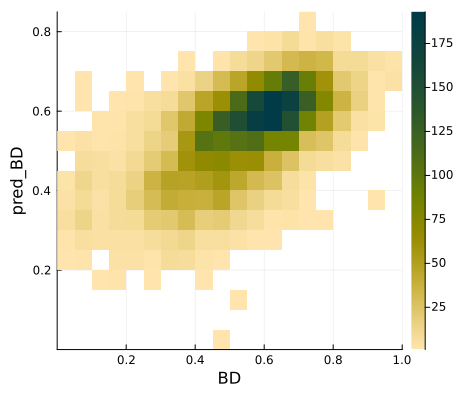

Plotting SOCconc: valid points = 56117


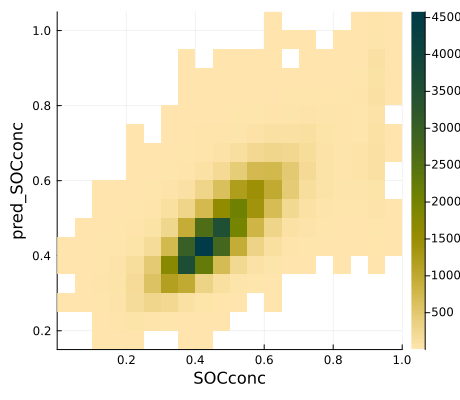

Plotting CF: valid points = 5194


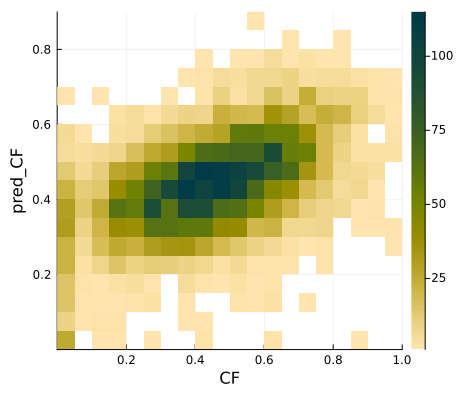

Plotting SOCdensity: valid points = 5194


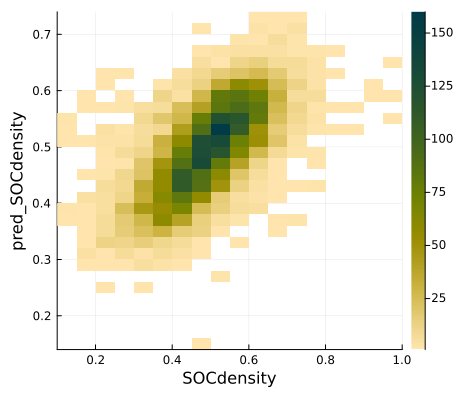

In [4]:
for tgt in ["BD", "SOCconc", "CF", "SOCdensity"]

    true_vals = rlt_pred[:, Symbol(tgt)]
    pred_vals = rlt_pred[:, Symbol("pred_", tgt)]

    # 过滤掉 invalid 值（避免 NaN 出图报错）
    mask = map(!isnan, true_vals) .& map(!isnan, pred_vals)
    x = true_vals[mask]
    y = pred_vals[mask]

    println("Plotting $tgt: valid points = ", length(x))

    plt = histogram2d(
        x, y;
        nbins = (30, 30),
        cbar = true,
        xlab = tgt,
        ylab = "pred_$tgt",
        color = cgrad(:bamako, rev=true),
        normalize = false,
        size = (460, 400),
    )

    display(plt)
end


Variable: pred_BD
  Valid count = 5194
  Min = 0.006714391708374012
  Max = 0.8085864543914796



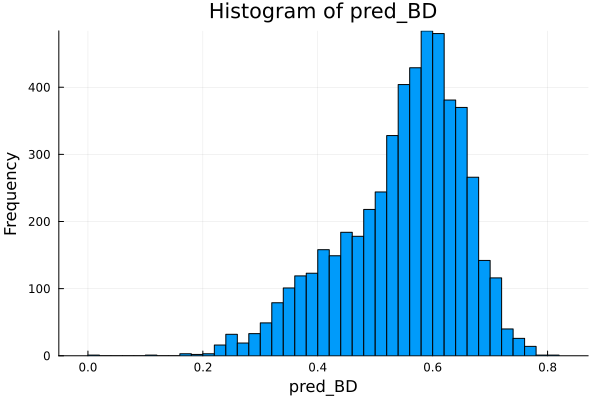

Variable: pred_SOCconc
  Valid count = 56117
  Min = 0.16775138378143306
  Max = 1.0



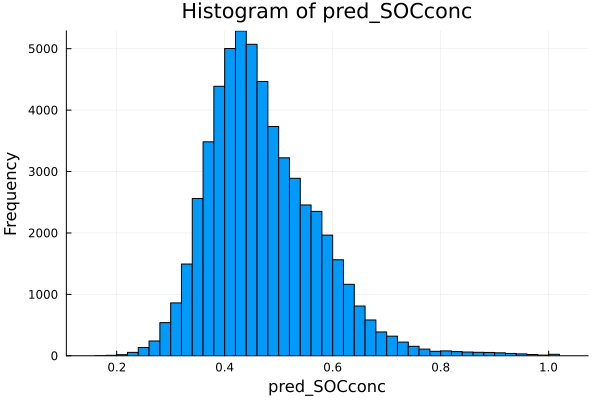

Variable: pred_CF
  Valid count = 5194
  Min = 0.0
  Max = 0.8505990266799928



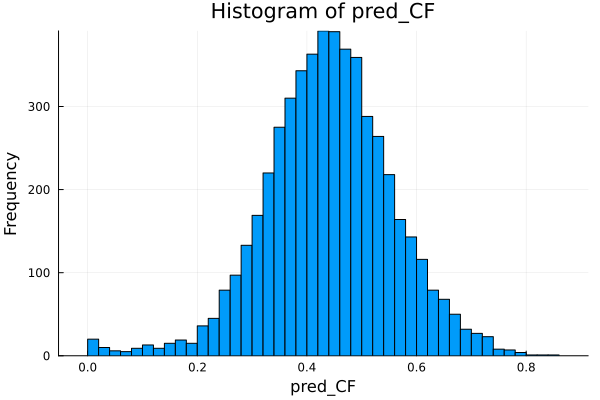

Variable: pred_SOCdensity
  Valid count = 5194
  Min = 0.1406529903411865
  Max = 0.7378935813903809



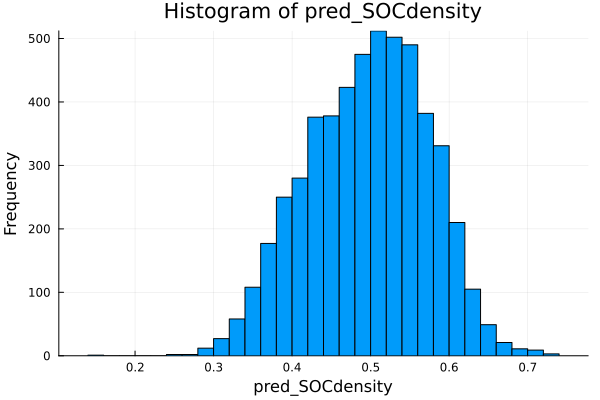

In [5]:
for col in ["pred_BD", "pred_SOCconc", "pred_CF", "pred_SOCdensity"]

    vals = rlt_pred[:, col]

    # 有效值（非 missing 且非 NaN）
    valid_vals = filter(x -> !ismissing(x) && !isnan(x), vals)

    n_valid = length(valid_vals)
    vmin = minimum(valid_vals)
    vmax = maximum(valid_vals)

    println("Variable: $col")
    println("  Valid count = $n_valid")
    println("  Min = $vmin")
    println("  Max = $vmax\n")

    histogram(
        vals;
        bins = 50,
        xlabel = col,
        ylabel = "Frequency",
        title = "Histogram of $col",
        lw = 1,
        legend = false
    )
    display(current())
end


In [6]:
println(size(rlt_pred))

(56117, 389)
